# Mercedes-Benz Greener Manufacturing

# importing libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [32]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print(train_data.shape)
print(test_data.shape)

(4209, 378)
(4209, 377)


In [33]:
for i in train_data.columns:
    data_type = train_data[i].dtype
    if data_type == 'object':
        print(i)

X0
X1
X2
X3
X4
X5
X6
X8


#### If for any column(s), the variance is equal to zero, then you need to remove those variable(s).

In [34]:
variance = pow(train_data.drop(columns={'ID','y'}).std(),2).to_dict()

null_cnt = 0
for key, value in variance.items():
    if(value==0):
        print('Name = ',key)
        null_cnt = null_cnt+1
print('No of columns which has zero variance = ',null_cnt)

Name =  X11
Name =  X93
Name =  X107
Name =  X233
Name =  X235
Name =  X268
Name =  X289
Name =  X290
Name =  X293
Name =  X297
Name =  X330
Name =  X347
No of columns which has zero variance =  12


In [35]:
train_data = train_data.drop(columns={'X11','X93','X107','X233','X235','X268','X289','X290','X293','X297','X330','X347'})
train_data.shape

(4209, 366)

### Check for null and unique values for test and train sets

In [36]:
train_data.isnull().sum().any()

False

# Apply label encoder

In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [38]:
train_data_feature = train_data.drop(columns={'y','ID'})
train_data_target = train_data.y
print(train_data_feature.shape)
print(train_data_target.shape)

(4209, 364)
(4209,)


In [39]:
train_data_feature.describe(include='object')

,X0,X1,X2,X3,X4,X5,X6,X8
count,4209,4209,4209,4209,4209,4209,4209,4209
unique,47,27,44,7,4,29,12,25
top,z,aa,as,c,d,v,g,j
freq,360,833,1659,1942,4205,231,1042,277


In [40]:
train_data_feature['X0'] = le.fit_transform(train_data_feature.X0)
train_data_feature['X1'] = le.fit_transform(train_data_feature.X1)
train_data_feature['X2'] = le.fit_transform(train_data_feature.X2)
train_data_feature['X3'] = le.fit_transform(train_data_feature.X3)
train_data_feature['X4'] = le.fit_transform(train_data_feature.X4)
train_data_feature['X5'] = le.fit_transform(train_data_feature.X5)
train_data_feature['X6'] = le.fit_transform(train_data_feature.X6)
train_data_feature['X8'] = le.fit_transform(train_data_feature.X8)

# PCA (Perform dimensionality reduction)

In [41]:
print(train_data_feature.shape)
print(train_data_target.shape)

(4209, 364)
(4209,)


In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.95)

In [43]:
pca.fit(train_data_feature, train_data_target)

PCA(n_components=0.95)

In [44]:
train_data_feature_trans = pca.fit_transform(train_data_feature)
print(train_data_feature_trans.shape)

(4209, 6)


# Predict your test_df values using XGBoost

### Building model using the train data set

In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

In [46]:
train_x,test_x,train_y,test_y = train_test_split(train_data_feature_trans,train_data_target,test_size=.3,random_state=7)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2946, 6)
(2946,)
(1263, 6)
(1263,)


### XGBoost's hyperparameters tuning

In [47]:
xgb_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.4, max_depth = 10, alpha = 6, 
                           n_estimators = 20)
model = xgb_reg.fit(train_x,train_y)
print('RMSE = ',sqrt(mean_squared_error(model.predict(test_x),test_y)))

[14:02:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
RMSE =  12.288794806074309


 ### - After tuning the hyperparameters to meet minimum RMSE, RMSE turned out as 12.29

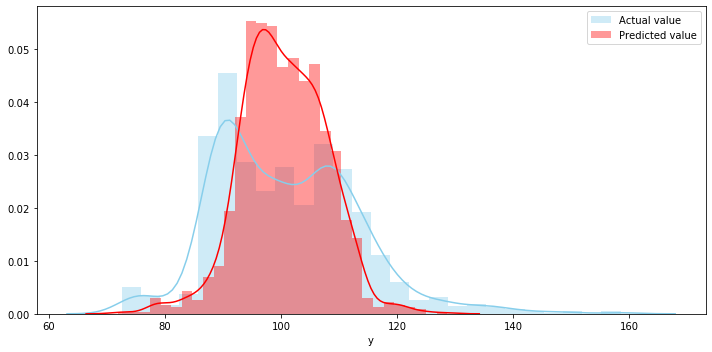

In [48]:
pred_test_y = model.predict(test_x)

plt.figure(figsize=(10,5))

sns.distplot(test_y[test_y<160], color="skyblue", label="Actual value")
sns.distplot(pred_test_y[pred_test_y<160] , color="red", label="Predicted value")
plt.legend()

plt.tight_layout()

### k-fold Cross Validation using XGBoost

In [49]:
dmatrix_train = xgb.DMatrix(data=train_data_feature_trans,label=train_data_target)

params = {'objective':'reg:linear', 'colsample_bytree': 0.3, 'learning_rate': 0.3, 'max_depth': 5, 'alpha': 10}

model_cv = xgb.cv(dtrain=dmatrix_train, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, 
                      metrics="rmse", as_pandas=True, seed=7)
model_cv.tail(4)

[14:02:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
31,8.935207,0.183408,11.060048,0.736219
32,8.880285,0.174860,11.044371,0.740167
33,8.849045,0.185328,11.049080,0.738352
34,8.792400,0.202135,11.043289,0.728256


# Prediction on test data set using XGBoost

### Preparing test data set

In [50]:
test_data = test_data.drop(columns={'X11','X93','X107','X233','X235','X268','X289','X290','X293','X297','X330','X347'})
test_data.shape

(4209, 365)

In [51]:
test_data.isnull().sum().any()

False

In [52]:
test_data_feature = test_data.drop(columns={'ID'})
print(test_data_feature.shape)

(4209, 364)


In [53]:
test_data_feature.describe(include='object')

,X0,X1,X2,X3,X4,X5,X6,X8
count,4209,4209,4209,4209,4209,4209,4209,4209
unique,49,27,45,7,4,32,12,25
top,ak,aa,as,c,d,v,g,e
freq,432,826,1658,1900,4203,246,1073,274


In [54]:
test_data_feature['X0'] = le.fit_transform(test_data_feature.X0)
test_data_feature['X1'] = le.fit_transform(test_data_feature.X1)
test_data_feature['X2'] = le.fit_transform(test_data_feature.X2)
test_data_feature['X3'] = le.fit_transform(test_data_feature.X3)
test_data_feature['X4'] = le.fit_transform(test_data_feature.X4)
test_data_feature['X5'] = le.fit_transform(test_data_feature.X5)
test_data_feature['X6'] = le.fit_transform(test_data_feature.X6)
test_data_feature['X8'] = le.fit_transform(test_data_feature.X8)

In [55]:
pca.fit(test_data_feature)

PCA(n_components=0.95)

In [56]:
test_data_feature_trans = pca.fit_transform(test_data_feature)
print(test_data_feature_trans.shape)

(4209, 6)


In [57]:
test_pred = model.predict(test_data_feature_trans)
test_pred

array([ 86.12015 ,  92.929794,  98.74635 , ...,  92.836525, 118.76457 ,
        98.46741 ], dtype=float32)

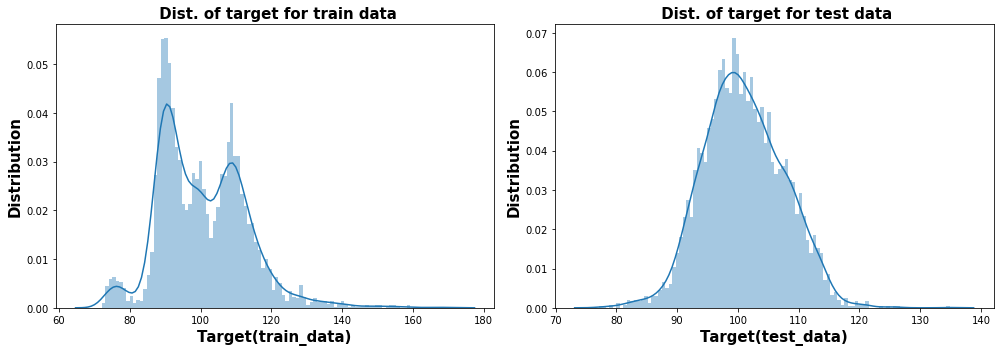

In [58]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

train_plot = sns.distplot(train_data_target[train_data_target<200], bins=100, kde=True, ax=ax[0])
train_plot.set_xlabel('Target(train_data)', weight='bold', size=15)
train_plot.set_ylabel('Distribution', weight='bold', size=15)
train_plot.set_title(' Dist. of target for train data', weight='bold', size=15)

test_plot = sns.distplot(test_pred[test_pred<200], bins=100, kde=True, ax=ax[1])
test_plot.set_xlabel('Target(test_data)', weight='bold', size=15)
test_plot.set_ylabel('Distribution', weight='bold', size=15)
test_plot.set_title(' Dist. of target for test data', weight='bold', size=15)

plt.tight_layout()

### This is a pictorial view for comparison between the target for training data-set and predicted target for testing data-set.